# Case Study 6.1 - NYC Taxi Trips

##### Case Study Description: To predict the trip duration of a New York taxi cab ride, we can build different types of features and evaluate them.
##### Datasets and Format: Multiple .csv files, loaded as pandas DataFrame objects
##### Tools Used: featuretools (deep feature synthesis library)
##### Why this Case Study? By following this case study steps, you can develop a trip predicting tool based on different types of feature   


In [1]:
!pip install featuretools==0.1.19

azure-datalake-store 0.0.19 has requirement msrest~=0.4.5, but you'll have msrest 0.5.0 which is incompatible.


# Import

In [1]:
import featuretools as ft
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import utils
from featuretools.primitives import (Count, Day, Hour, Max, Mean, Median, Min,
                                     Minute, Month, Std, Sum, Week, Weekday,
                                     Weekend)
from sklearn.ensemble import GradientBoostingRegressor
from utils import (compute_features, feature_importances, load_nyc_taxi_data,
                   preview)

In [2]:
%matplotlib inline

In [4]:
assert ft.__version__ == '0.1.19', 'Make sure you run the command above with the correct version.'

# Data

- Use `load_nyc_taxi_data` to get the data.
- Use `preview` to preview the data.
- Create a histogram of the `trip_duration` column of the `trips` table.

In [3]:
# Your code here to load, preview and visualize data
trips, pickup_neighborhoods, dropoff_neighborhoods = load_nyc_taxi_data()
preview(trips, 10)



,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
0,514030,2,2016-04-02 00:00:00,2016-04-02 00:17:00,1,2.46,-73.987595,40.754711,-73.959633,40.762836,1,1039,AA,K
1,514031,1,2016-04-02 00:00:00,2016-04-02 00:24:00,2,7.90,-73.924713,40.745567,-73.972763,40.793354,1,1454,L,U
2,514032,1,2016-04-02 00:00:00,2016-04-02 00:19:00,1,1.00,-73.989800,40.732994,-74.000557,40.742622,1,1168,H,Q
3,514033,2,2016-04-02 00:00:00,2016-04-02 00:01:00,1,0.02,-73.987465,40.719822,-73.987289,40.720016,2,35,AC,AC
4,514034,1,2016-04-02 00:01:00,2016-04-02 00:58:00,2,19.00,-73.790131,40.643429,-73.975594,40.779327,1,3470,G,I
5,514035,1,2016-04-02 00:01:00,2016-04-02 00:09:00,2,1.50,-73.981956,40.765518,-73.968124,40.753407,1,458,AR,N
6,514036,1,2016-04-02 00:01:00,2016-04-02 00:05:00,1,1.50,-73.980019,40.780594,-73.968132,40.799595,2,213,AV,U
7,514037,1,2016-04-02 00:01:00,2016-04-02 00:20:00,1,4.20,-73.990501,40.756561,-73.986008,40.719414,2,1142,AA,AC
8,514038,1,2016-04-02 00:01:00,2016-04-02 00:10:00,1,0.60,-73.986198,40.730492,-73.991798,40.722240,1,501,AT,AC
9,514039,1,2016-04-02 00:01:00,2016-04-02 00:17:00,1,0.60,-73.990959,40.734890,-74.001816,40.739319,1,954,R,Q


In [6]:
preview(pickup_neighborhoods,10)



,neighborhood_id,latitude,longitude
0,AH,40.804349,-73.961716
1,Z,40.715828,-73.954298
2,D,40.750179,-73.992557
3,AT,40.729670,-73.981693
4,AG,40.749843,-74.003458
5,K,40.766809,-73.956886
6,R,40.738211,-73.987544
7,A,40.761492,-73.975899
8,AK,40.764723,-73.966696
9,U,40.793597,-73.969822


In [7]:
preview(dropoff_neighborhoods,10)

,neighborhood_id,latitude,longitude
0,C,40.783780,-73.953145
1,S,40.836792,-73.934381
2,AL,40.818445,-73.948046
3,J,40.799573,-73.940427
4,AV,40.776270,-73.982322
5,D,40.750179,-73.992557
6,T,40.698772,-73.815138
7,U,40.793597,-73.969822
8,I,40.785005,-73.976050
9,AO,40.747126,-73.985336


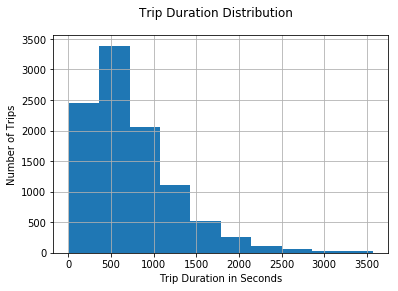

In [5]:
trips['trip_duration'].hist()
plt.xlabel('Trip Duration in Seconds')
plt.ylabel('Number of Trips')
plt.suptitle('Trip Duration Distribution')
plt.show()

In [9]:
trips.describe()

,id,vendor_id,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,519029.50000,1.527400,1.698100,2.743312,-73.976702,40.749273,-73.974212,40.750304,746.098900
std,2886.89568,0.499274,1.303045,3.134647,0.032755,0.027119,0.031928,0.030314,525.049496
min,514030.00000,1.000000,1.000000,0.000000,-74.027252,40.632393,-74.027252,40.630280,2.000000
25%,516529.75000,1.000000,1.000000,1.000000,-73.992891,40.733330,-73.992287,40.732718,364.000000
50%,519029.50000,2.000000,1.000000,1.700000,-73.983452,40.750420,-73.981422,40.752056,616.000000
75%,521529.25000,2.000000,2.000000,3.200000,-73.968937,40.766482,-73.962952,40.768576,988.000000
max,524029.00000,2.000000,6.000000,32.090000,-73.773987,40.849663,-73.776260,40.849686,3573.000000


In [6]:
trips_500_2000=trips[(trips.trip_duration>=500) & (trips.trip_duration<=2000)]

trips_more_than_average_duration=trips[(trips.trip_duration>=746)]
trips_more_than_average_duration.shape[0]

trips_less_than_average_duration=trips[(trips.trip_duration<=746)]
trips_less_than_average_duration.shape[0]

6033

In [7]:
total_trips=trips.shape[0]
print(total_trips)
# trips having trip duration between 500 and 2000 seconds
trips_500_2000=trips[(trips.trip_duration>=500) & (trips.trip_duration<=2000)]
print(trips_500_2000.shape[0])

# trips having trip duration more than average trip duration
trips_more_than_average_duration=trips[(trips.trip_duration>=746)]
trips_more_than_average_duration.shape[0]

# trips having trip duration less than average trip duration
trips_less_than_average_duration=trips[(trips.trip_duration<=746)]
trips_less_than_average_duration.shape[0]

10000
5786


6033

In [13]:
#trips with only one passenger
trips[trips.passenger_count==1].shape[0]

6793

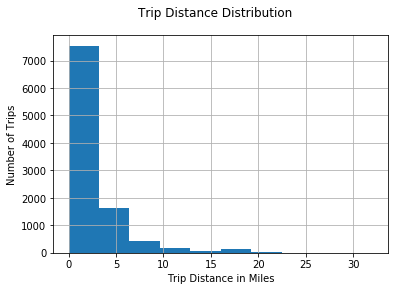

In [14]:
trips['trip_distance'].hist()
plt.xlabel('Trip Distance in Miles')
plt.ylabel('Number of Trips')
plt.suptitle('Trip Distance Distribution')
plt.show()

In [15]:
# trips having trip distance less than 8 miles

trips_less_than_8miles=trips[trips.trip_distance<8]
print(trips_less_than_8miles.shape[0])

9435


# Entities and Relationships

Construct a dictionary of entities and relationships. You can read about the format of these objects `here`.

In [8]:
# Construct entities and relationships dicts
entities = {
    "trips": (trips, "id", 'pickup_datetime'),
    "pickup_neighborhoods": (pickup_neighborhoods, "neighborhood_id"),
    "dropoff_neighborhoods": (dropoff_neighborhoods, "neighborhood_id"),
}

relationships = [("pickup_neighborhoods", "neighborhood_id", "trips", "pickup_neighborhood"),
                 ("dropoff_neighborhoods", "neighborhood_id", "trips", "dropoff_neighborhood")]


# Transform Primitives

In [9]:
trans_primitives = [Weekend]


In [10]:
# Then, use featuretools.dfs to get the features
# See https://docs.featuretools.com/generated/featuretools.dfs.html
# target entity should match name for trips entity in your entities dictionary
# no agg_primitives yet
# ignore the lat/long for dropoff and pickup

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

In [11]:
# Print out the features you just made
print(f"Number of features: {len(features)}")
features

Number of features: 13


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]

In [13]:
# Use compute_features to get the feature matrix
# compute_features expects the following args:
#      1. list of features from dfs
#      2. dataframe with id and pickup_datetime columns
feature_matrix = compute_features(features, trips[['id', 'pickup_datetime']])
preview(feature_matrix, 20)

Elapsed: 00:01 | Remaining: 00:00 | Progress: 100%|██████████|| Calculated: 1/1 cutoff times
Finishing computing...


,trip_distance,trip_duration,IS_WEEKEND(dropoff_datetime),dropoff_neighborhood = D,dropoff_neighborhood = AA,dropoff_neighborhood = H,dropoff_neighborhood = P,dropoff_neighborhood = AR,dropoff_neighborhood = AD,dropoff_neighborhood = A,...,pickup_neighborhood = AO,pickup_neighborhood = AD,pickup_neighborhood = Q,pickup_neighborhood = AR,pickup_neighborhood = AP,pickup_neighborhood = H,pickup_neighborhoods.latitude,IS_WEEKEND(pickup_datetime),dropoff_neighborhoods.latitude,vendor_id
id,,,,,,,,,,,,,,,,,,,,,
514030,2.46,1039,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,40.757707,True,40.766809,2
514031,7.90,1454,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,40.744928,True,40.793597,1
514032,1.00,1168,True,0,0,0,0,0,0,0,...,0,0,0,0,0,1,40.729652,True,40.740333,1
514033,0.02,35,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,40.720245,True,40.720245,2
514034,19.00,3470,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,40.646194,True,40.785005,1
514035,1.50,458,True,0,0,0,0,0,0,0,...,0,0,0,1,0,0,40.766488,True,40.756598,1
514036,1.50,213,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,40.776270,True,40.793597,1
514037,4.20,1142,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,40.757707,True,40.720245,1
514038,0.60,501,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,40.729670,True,40.720245,1


# First Model

In [14]:
# Split feature matrix (75% train, 25% test) using utils.train_test_fm
# This function also takes care of removing `trip_duration` column from feature matrix
X_train, y_train, X_test, y_test = utils.get_train_test_fm(feature_matrix,.75)

In [15]:
# Use np.log(x + 1) to take the log of a particular vector x - this helps create a more linear relationship
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

In [16]:
# Then, create a GradientBoostingRegressor
# Fit to training
model = GradientBoostingRegressor(verbose=True)
model.fit(X_train, y_train)
# Score on testing
model.score(X_test, y_test) # This is the R^2 value of the prediction

      Iter       Train Loss   Remaining Time 
         1           0.4736            5.84s
         2           0.4148            5.50s
         3           0.3661            5.85s
         4           0.3266            5.83s
         5           0.2934            5.64s
         6           0.2665            5.70s
         7           0.2441            5.59s
         8           0.2257            5.57s
         9           0.2103            5.58s
        10           0.1973            5.38s
        20           0.1434            4.40s
        30           0.1312            3.80s
        40           0.1248            3.09s
        50           0.1218            2.49s
        60           0.1191            1.92s
        70           0.1174            1.39s
        80           0.1158            0.91s
        90           0.1147            0.44s
       100           0.1137            0.00s


0.7527788676087426

In [17]:
features_wo_transprimitive = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=[],
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)



In [18]:
print(f"Number of features: {len(features_wo_transprimitive)}")
features

Number of features: 11


[<Feature: trip_distance>,
 <Feature: trip_duration>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: dropoff_neighborhood>,
 <Feature: dropoff_neighborhoods.longitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: payment_type>,
 <Feature: passenger_count>,
 <Feature: pickup_neighborhood>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: vendor_id>]

In [19]:
feature_matrix_wo_transprimitive = compute_features(features_wo_transprimitive, trips[['id', 'pickup_datetime']])
preview(feature_matrix_wo_transprimitive, 20)



Elapsed: 00:01 | Remaining: 00:00 | Progress: 100%|██████████|| Calculated: 1/1 cutoff times
Finishing computing...


,vendor_id,trip_duration,dropoff_neighborhoods.longitude,dropoff_neighborhood = D,dropoff_neighborhood = AA,dropoff_neighborhood = H,dropoff_neighborhood = P,dropoff_neighborhood = AR,dropoff_neighborhood = AD,dropoff_neighborhood = A,...,pickup_neighborhood = AD,pickup_neighborhood = Q,pickup_neighborhood = AR,pickup_neighborhood = AP,pickup_neighborhood = H,trip_distance,payment_type,dropoff_neighborhoods.latitude,passenger_count,pickup_neighborhoods.longitude
id,,,,,,,,,,,,,,,,,,,,,
514030,2,1039,-73.956886,0,0,0,0,0,0,0,...,0,0,0,0,0,2.46,1,40.766809,1,-73.986446
514031,1,1454,-73.969822,0,0,0,0,0,0,0,...,0,0,0,0,0,7.90,1,40.793597,2,-73.919159
514032,1,1168,-74.005107,0,0,0,0,0,0,0,...,0,0,0,0,1,1.00,1,40.740333,1,-73.991595
514033,2,35,-73.987205,0,0,0,0,0,0,0,...,0,0,0,0,0,0.02,2,40.720245,1,-73.987205
514034,1,3470,-73.976050,0,0,0,0,0,0,0,...,0,0,0,0,0,19.00,1,40.785005,2,-73.785073
514035,1,458,-73.968312,0,0,0,0,0,0,0,...,0,0,1,0,0,1.50,1,40.756598,2,-73.983998
514036,1,213,-73.969822,0,0,0,0,0,0,0,...,0,0,0,0,0,1.50,2,40.793597,1,-73.982322
514037,1,1142,-73.987205,0,0,0,0,0,0,0,...,0,0,0,0,0,4.20,2,40.720245,1,-73.986446
514038,1,501,-73.987205,0,0,0,0,0,0,0,...,0,0,0,0,0,0.60,1,40.720245,1,-73.981693


In [20]:
X_train, y_train, X_test, y_test = utils.get_train_test_fm(feature_matrix_wo_transprimitive,.75)
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)
model = GradientBoostingRegressor(verbose=True)
model.fit(X_train, y_train)
model.score(X_test, y_test)


      Iter       Train Loss   Remaining Time 
         1           0.4736            7.53s
         2           0.4148            6.69s
         3           0.3661            6.16s
         4           0.3266            6.45s
         5           0.2934            6.18s
         6           0.2665            6.28s
         7           0.2441            6.10s
         8           0.2257            5.94s
         9           0.2103            5.90s
        10           0.1973            5.74s
        20           0.1434            4.59s
        30           0.1312            4.01s
        40           0.1248            3.21s
        50           0.1218            2.55s
        60           0.1191            1.97s
        70           0.1174            1.46s
        80           0.1158            0.95s
        90           0.1147            0.46s
       100           0.1137            0.00s


0.7527739778067354

# More Transform Primitives

In [21]:
# Make list of transform primtivies that contain new primitives described in the instruction manual
trans_primitives = [Minute, Hour, Day, Week, Month, Weekday, Weekend]


In [22]:
# Compute features

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

print(f"Number of features: {len(features)}")
features

Number of features: 25


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MINUTE(dropoff_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: HOUR(dropoff_datetime)>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: DAY(dropoff_datetime)>,
 <Feature: WEEK(pickup_datetime)>,
 <Feature: WEEK(dropoff_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: MONTH(dropoff_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: WEEKDAY(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]

In [23]:
# Compute feature matrix
feature_matrix = compute_features(features, trips[['id', 'pickup_datetime']])
preview(feature_matrix, 5)


Elapsed: 00:01 | Remaining: 00:00 | Progress: 100%|██████████|| Calculated: 1/1 cutoff times
Finishing computing...


,pickup_neighborhoods.longitude,WEEK(dropoff_datetime),DAY(pickup_datetime),dropoff_neighborhoods.latitude,payment_type,MINUTE(dropoff_datetime),HOUR(dropoff_datetime),IS_WEEKEND(dropoff_datetime),IS_WEEKEND(pickup_datetime),WEEKDAY(dropoff_datetime),...,dropoff_neighborhood = D,dropoff_neighborhood = AA,dropoff_neighborhood = H,dropoff_neighborhood = P,dropoff_neighborhood = AR,dropoff_neighborhood = AD,dropoff_neighborhood = A,dropoff_neighborhood = AB,dropoff_neighborhood = AV,dropoff_neighborhood = AP
id,,,,,,,,,,,,,,,,,,,,,
514030,-73.986446,13,2,40.766809,1,17,0,True,True,5,...,0,0,0,0,0,0,0,0,0,0
514031,-73.919159,13,2,40.793597,1,24,0,True,True,5,...,0,0,0,0,0,0,0,0,0,0
514032,-73.991595,13,2,40.740333,1,19,0,True,True,5,...,0,0,0,0,0,0,0,0,0,0
514033,-73.987205,13,2,40.720245,2,1,0,True,True,5,...,0,0,0,0,0,0,0,0,0,0
514034,-73.785073,13,2,40.785005,1,58,0,True,True,5,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# Re-split feature matrix
X_train, y_train, X_test, y_test = utils.get_train_test_fm(feature_matrix,.75)
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

In [26]:
# Train and score NEW model

model = GradientBoostingRegressor(verbose=True)
model.fit(X_train, y_train)
model.score(X_test, y_test)

      Iter       Train Loss   Remaining Time 
         1           0.4736            7.81s
         2           0.4148            7.19s
         3           0.3661            6.65s
         4           0.3264            6.34s
         5           0.2930            6.17s
         6           0.2660            6.02s
         7           0.2432            5.91s
         8           0.2245            5.70s
         9           0.2090            5.67s
        10           0.1960            5.62s
        20           0.1362            4.68s
        30           0.1200            3.96s
        40           0.1126            3.34s
        50           0.1079            2.71s
        60           0.1047            2.11s
        70           0.1016            1.54s
        80           0.0986            1.00s
        90           0.0938            0.49s
       100           0.0899            0.00s


0.8061480677536478

# Aggregation Primitives

In [27]:
# Make list of transform primtivies that are the same as above
trans_primitives = [Minute, Hour, Day, Week, Month, Weekday, Weekend]

# Make a list of aggregation primitives containing Count, Sum, Mean, Median, Std, Max, Min
aggregation_primitives = [Count, Sum, Mean, Median, Std, Max, Min]

In [28]:
# Compute features
features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=aggregation_primitives,
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                         
                                              
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

print(f"Number of features: {len(features)}")
features



Number of features: 75


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MINUTE(dropoff_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: HOUR(dropoff_datetime)>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: DAY(dropoff_datetime)>,
 <Feature: WEEK(pickup_datetime)>,
 <Feature: WEEK(dropoff_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: MONTH(dropoff_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: WEEKDAY(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>,
 <Feature: pickup_neighborhoods.COUNT(trips)>,
 <Feature: pickup_neighborhoods.SUM(trips.vendor_id)>,
 <Fe

In [29]:
# Compute feature matrix

feature_matrix = compute_features(features, trips[['id', 'pickup_datetime']])
preview(feature_matrix, 5)

Elapsed: 00:04 | Remaining: 00:00 | Progress: 100%|██████████|| Calculated: 1/1 cutoff times
Finishing computing...


,pickup_neighborhoods.SUM(trips.trip_distance),pickup_neighborhoods.SUM(trips.trip_duration),pickup_neighborhoods.longitude,dropoff_neighborhoods.longitude,dropoff_neighborhoods.MEDIAN(trips.passenger_count),pickup_neighborhoods.STD(trips.trip_duration),pickup_neighborhoods.MIN(trips.passenger_count),dropoff_neighborhoods.STD(trips.passenger_count),pickup_neighborhoods.STD(trips.passenger_count),trip_duration,...,dropoff_neighborhoods.COUNT(trips),pickup_neighborhoods.MAX(trips.trip_distance),MINUTE(pickup_datetime),pickup_neighborhoods.MAX(trips.passenger_count),MINUTE(dropoff_datetime),dropoff_neighborhoods.MEDIAN(trips.vendor_id),dropoff_neighborhoods.STD(trips.trip_duration),pickup_neighborhoods.MIN(trips.vendor_id),MONTH(pickup_datetime),dropoff_neighborhoods.latitude
id,,,,,,,,,,,,,,,,,,,,,
514030,NaN,NaN,-73.986446,-73.956886,NaN,NaN,NaN,NaN,NaN,1039,...,0.0,NaN,0,NaN,17,NaN,NaN,NaN,4,40.766809
514031,NaN,NaN,-73.919159,-73.969822,NaN,NaN,NaN,NaN,NaN,1454,...,0.0,NaN,0,NaN,24,NaN,NaN,NaN,4,40.793597
514032,NaN,NaN,-73.991595,-74.005107,NaN,NaN,NaN,NaN,NaN,1168,...,0.0,NaN,0,NaN,19,NaN,NaN,NaN,4,40.740333
514033,NaN,NaN,-73.987205,-73.987205,NaN,NaN,NaN,NaN,NaN,35,...,0.0,NaN,0,NaN,1,NaN,NaN,NaN,4,40.720245
514034,NaN,NaN,-73.785073,-73.976050,NaN,NaN,NaN,NaN,NaN,3470,...,0.0,NaN,1,NaN,58,NaN,NaN,NaN,4,40.785005


In [63]:
# feature_matrix.iloc[:,40:50].head(5)
feature_matrix['IS_WEEKEND(dropoff_datetime)'].describe()
feature_matrix['IS_WEEKEND(pickup_datetime)'].describe()

count     10000
unique        1
top        True
freq      10000
Name: IS_WEEKEND(pickup_datetime), dtype: object

In [30]:
# Re-split feature matrix
X_train, y_train, X_test, y_test = utils.get_train_test_fm(feature_matrix,.75)
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

In [31]:
# Train and score NEW model
model = GradientBoostingRegressor(verbose=True)
model.fit(X_train, y_train)
model.score(X_test, y_test) 


      Iter       Train Loss   Remaining Time 
         1           0.4736            7.00s
         2           0.4148            6.75s
         3           0.3661            6.62s
         4           0.3264            6.76s
         5           0.2930            6.46s
         6           0.2660            6.13s
         7           0.2432            5.81s
         8           0.2245            5.70s
         9           0.2090            5.59s
        10           0.1960            5.61s
        20           0.1362            4.82s
        30           0.1200            4.09s
        40           0.1126            3.36s
        50           0.1079            2.70s
        60           0.1047            2.07s
        70           0.1016            1.50s
        80           0.0986            0.98s
        90           0.0938            0.48s
       100           0.0899            0.00s


0.8060336822773623

# Evaluate on Test Data

In [32]:
# Use .predict() function on your latest model to get y_pred from X_test
y_pred = model.predict(X_test)
y_pred = np.exp(y_pred) - 1 

In [72]:
# Print some of the predictions
y_pred[:10]


array([ 453.4415368 ,  666.8066337 ,  634.00494622,  617.34019506,
        407.96332751, 1424.64561908,  465.09882412, 1151.59896332,
        645.79664106,  557.34354061])

(array([418., 739., 547., 301., 253., 100.,  61.,  40.,  29.,  12.]),
 array([  13.00778932,  284.36132154,  555.71485376,  827.06838598,
        1098.4219182 , 1369.77545042, 1641.12898264, 1912.48251486,
        2183.83604708, 2455.1895793 , 2726.54311152]),
 <a list of 10 Patch objects>)

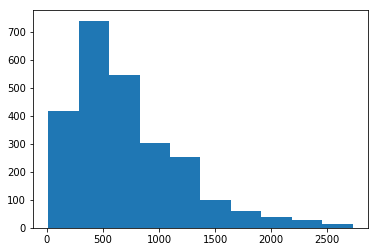

In [34]:
# Create histogram of predictions
matplotlib.pyplot.hist(y_pred)

# Feature Importance

In [41]:
# Compute feature importance of model
# You can use the feature_importances function we defined for you
feature_importances(model, feature_matrix.columns, n=25)
# Or, see the feature_importances_ attribute of our model
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

1: Feature: pickup_neighborhood = AA, 0.325
2: Feature: pickup_neighborhood = H, 0.109
3: Feature: pickup_neighborhoods.SUM(trips.trip_duration), 0.103
4: Feature: pickup_neighborhood = AO, 0.084
5: Feature: MONTH(dropoff_datetime), 0.072
6: Feature: pickup_neighborhoods.SUM(trips.vendor_id), 0.069
7: Feature: pickup_neighborhoods.SUM(trips.trip_distance), 0.062
8: Feature: pickup_neighborhoods.MEDIAN(trips.trip_distance), 0.058
9: Feature: dropoff_neighborhoods.MEAN(trips.trip_duration), 0.029
10: Feature: pickup_neighborhood = Q, 0.012
11: Feature: dropoff_neighborhoods.longitude, 0.012
12: Feature: pickup_neighborhoods.longitude, 0.009
13: Feature: pickup_neighborhoods.MIN(trips.trip_duration), 0.009
14: Feature: dropoff_neighborhood = AD, 0.007
15: Feature: pickup_neighborhoods.MIN(trips.passenger_count), 0.006
16: Feature: dropoff_neighborhood = AB, 0.005
17: Feature: pickup_neighborhood = AD, 0.004
18: Feature: pickup_neighborhood = AB, 0.004
19: Feature: dropoff_neighborhood = P

<hr>

Great job! Now, make sure you check out the **Conclusion** section of the [instruction manual](https://courses.edx.org/asset-v1:MITxPRO+DSx+2T2018+type@asset+block@6.1_instruction_manual.html) to wrap up this case study properly.